### Figure generation notebook for Visium bulk comparisons with MERFISH

**Description**
This notebook is to generate SI figures for the comparison of Visium (public datasets) and MERFISH spatial transcriptomics datasets using mouse liver and kidney samples. The idea is to replicate the Figure 3 in the main text (which was done for MERFISH and scRNA-seq) for different spatial transcriptomics technology (Visium, sequencing-based) to see how much correlation we'd expect between spatial transcriptomics technologies and MERFISH.

**Resources (Public Visium datasets)**
- mouse liver: https://livercellatlas.org/download.php from Spatial proteogenomics paper (link)
- mouse kidney: https://www.rebuildingakidney.org/chaise/record/#2/Common:Collection/RID=17-E9J6 (1 dataset, "sham" which was used as a Control in https://jasn.asnjournals.org/content/33/2/279 paper.)

In [21]:
import os
import sys
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
import matplotlib as mpl
import numpy as np
import anndata as ad
import scanpy as sc
import string
import seaborn as sns


mpl.rcParams.update(mpl.rcParamsDefault) #Reset rcParams to default
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # Colors in this style

# Plotting style function (run this before plotting the final figure)
def set_plotting_style():
    plt.style.use('seaborn-paper')
    plt.rc('axes', labelsize=12)
    plt.rc('axes', titlesize=12)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.rc('legend', fontsize=10)
    plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
    plt.rc('xtick.major', pad=2)
    plt.rc('ytick.major', pad=2)
    plt.rc('mathtext', fontset='stixsans', sf='sansserif')
    plt.rc('figure', figsize=[10,9])
    plt.rc('svg', fonttype='none') 

# load the sc-utilities
sys.path.append("/home/yangjoon.kim/single-cell-utilities/spatial/")
import convert_pipeline_outputs_h5ad

### Mouse liver

Mouse liver Visium datasets. We took the count matrices (cell x gene) from https://livercellatlas.org/download.php



In [464]:
# Load the public visium datasets 
# mouse liver (total of 5 datasets)
visium_liver_path = "/mnt/ibm_lg/spatial-seq/vizgen-MACA-comparison-paper/data/Visium_public/liver/individual_visium_samples/"

files = os.listdir(visium_liver_path)

# visium_liver=sc.AnnData()
# first anndata
visium_liver=sc.read_10x_h5(visium_liver_path+files[0])
visium_liver.obs["sample"] = "JBO003"


# define a dataframe to save the result (pseudo-bulk counts per gene)
pseudo_bulk_counts_perGene = pd.DataFrame()

for sample in files:
    adata_temp =  sc.read_10x_h5(visium_liver_path+sample)
    sample_id = sample.split(".")[0][-6:]
    df_temp = pd.DataFrame(adata_temp.X.todense(),
                           columns=adata_temp.var_names)
    # compute the pseudo-bulk counts per gene (across ALL Spots)
    pseudo_bulk_counts_perGene.loc[:,sample_id] = np.sum(df_temp,0)

pseudo_bulk_counts_perGene


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


,JBO003,JBO002,JBO004,CAP002,JBO001
Xkr4,0.0,0.0,0.0,0.0,0.0
Gm1992,0.0,0.0,0.0,0.0,0.0
Gm37381,0.0,0.0,0.0,0.0,0.0
Rp1,0.0,0.0,0.0,0.0,0.0
Sox17,71.0,79.0,113.0,30.0,62.0
...,...,...,...,...,...
AC168977.1,0.0,0.0,0.0,0.0,0.0
AC149090.1,1889.0,4009.0,3527.0,785.0,3679.0
CAAA01118383.1,1127.0,1192.0,1722.0,289.0,1317.0
Vmn2r122,0.0,0.0,0.0,0.0,0.0


### Compute the pseudo-bulk transcript counts for all genes per sample


In [465]:
# we need to get a subset of genes that are present in both this Visium dataset and the MACA dataset
pseudo_bulk_counts_perGene.index

Index(['Xkr4', 'Gm1992', 'Gm37381', 'Rp1', 'Sox17', 'Gm37323', 'Mrpl15',
       'Lypla1', 'Gm37988', 'Tcea1',
       ...
       'AC125149.1', 'AC125149.2', 'AC125149.4', 'AC234645.1', 'AC168977.2',
       'AC168977.1', 'AC149090.1', 'CAAA01118383.1', 'Vmn2r122',
       'CAAA01147332.1'],
      dtype='object', length=31053)

In [466]:
pseudo_bulk_counts_perGene_liver = np.mean(pseudo_bulk_counts_perGene,1)
pseudo_bulk_counts_perGene_liver

Xkr4                 0.000000
Gm1992               0.000000
Gm37381              0.000000
Rp1                  0.000000
Sox17               71.000000
                     ...     
AC168977.1           0.000000
AC149090.1        2777.800049
CAAA01118383.1    1129.400024
Vmn2r122             0.000000
CAAA01147332.1      22.000000
Length: 31053, dtype: float32

### Mouse kidney

In [25]:
# mouse kidney (8-10 weeks old)
visium_kidney_path = "/mnt/ibm_lg/spatial-seq/vizgen-MACA-comparison-paper/data/Visium_public/kidney/fsham_137_processed/outs/"
output_dir = "/mnt/ibm_lg/spatial-seq/vizgen-MACA-comparison-paper/data/Visium_public/kidney/"
visium_kidney =  convert_pipeline_outputs_h5ad.convert_visium_output_to_h5ad(visium_kidney_path, output_dir, option=False)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/yangjoon.kim/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical
/home/yangjoon.kim/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'genome' as categorical


In [26]:
visium_kidney

AnnData object with n_obs × n_vars = 1617 × 32285
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial', 'X_spatial'

In [51]:
visium_kidney.obsm["spatial"]

array([[6710, 7863],
       [5706, 2806],
       [6907, 3753],
       ...,
       [3587, 5292],
       [4429, 6174],
       [6063, 2734]])

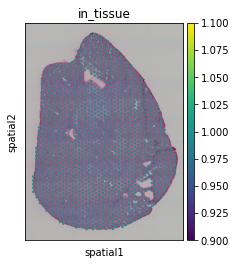

In [27]:
sc.pl.spatial(visium_kidney, color="in_tissue")

In [67]:
# check if the adata.X is raw counts
np.sum(visium_kidney.X.todense(),1)

matrix([[ 5855.],
        [ 6619.],
        [ 3675.],
        ...,
        [ 6011.],
        [13049.],
        [ 3692.]], dtype=float32)

In [170]:
df_counts = pd.DataFrame(visium_kidney.X.todense(),
                         columns = visium_kidney.var_names)
df_counts

pseudo_bulk_counts_perGene_kidney = np.sum(df_counts)
pseudo_bulk_counts_perGene_kidney


Xkr4            0.0
Gm1992          0.0
Gm19938         0.0
Gm37381         0.0
Rp1             1.0
              ...  
AC124606.1      0.0
AC133095.2      0.0
AC133095.1      0.0
AC234645.1      0.0
AC149090.1    631.0
Length: 32285, dtype: float32

In [182]:
# just out of curiosity, compute the number of genes which have at least one count across all cells
pseudo_bulk_counts_perGene_kidney[pseudo_bulk_counts_perGene_kidney!=0]

Rp1                  1.0
Sox17              129.0
Gm37587              1.0
Mrpl15             725.0
Lypla1            2188.0
                   ...  
Vamp7              252.0
Spry3                4.0
Tmlhe               32.0
CAAA01147332.1       1.0
AC149090.1         631.0
Length: 17686, dtype: float32

## Load the MACA datasets as well as Vizgen datasets

In [264]:
# Load data
dataPath = '/mnt/ibm_lg/spatial-seq/MERlin_Analysis/ProcessedResults/BulkCounts'

experimentNames = ['Msliver_VZG116_021121',
                   'Msliver_VZG116_021221',
                   'Msliver_VZG116_021621',
                   'Msliver_VZG116_021721',
                   'MsLiver_Cellbound_VZG116_V1_JH_09-18-2021',
                   'MsKidney_CellBoundary_VZG116_111921',
                   'MsKidney_CellBoundary_VZG116_121021']
bulkCounts = []

for i in range(len(experimentNames)):
    bulkCounts.append(pd.read_csv(os.path.join(
    dataPath, experimentNames[i] + '_BulkRNACounts.csv')))

print('Bulk RNA counts loaded.')

# MACA data
MACA = pd.read_csv('/mnt/ibm_lg/spatial-seq/vizgen-MACA-comparison-paper/data/TabulaMurisSenis/190214_A00111_0269_AHH3J3DSXX__190214_A00111_0270_BHHMFWDSXX.csv',
                  index_col=0)
MACA_meta = pd.read_csv('/mnt/ibm_lg/spatial-seq/vizgen-MACA-comparison-paper/data/TabulaMurisSenis/MACA_Bulk_metadata.csv')

# Use only mice that are 18 months or younger
#ages = ['6','3','18','1','12','9','15']
ages = ['3'] # Use only 3 month old mice
ind = MACA_meta['characteristics: age'].isin(ages)
samplesToKeep = MACA_meta['Sample name'][ind]
samplesToKeep = [s + '.gencode.vM19' for s in samplesToKeep] # Append the suffix to get the sample names consistent

MACA = MACA.loc[:, samplesToKeep]
MACA_meta = MACA_meta.loc[ind]
print('MACA results loaded.')

Bulk RNA counts loaded.
MACA results loaded.


### extra Panel : correlation between Visium and MACA bulk RNA-seq (mouse liver)

In [467]:
pseudo_bulk_counts_perGene_liver.index = pseudo_bulk_counts_perGene_liver.index.str.lower()
pseudo_bulk_counts_perGene_liver

xkr4                 0.000000
gm1992               0.000000
gm37381              0.000000
rp1                  0.000000
sox17               71.000000
                     ...     
ac168977.1           0.000000
ac149090.1        2777.800049
caaa01118383.1    1129.400024
vmn2r122             0.000000
caaa01147332.1      22.000000
Length: 31053, dtype: float32

In [468]:
#MACA plates that are liver tissue
liver_plates = MACA_meta['Sample name'].copy()[MACA_meta['source name'].str.contains('Liver')] #Plates containing liver experiments
liver_plate_strings = liver_plates.to_list() #Convert to list of strings
liver_plate_strings = [s + '.gencode.vM19' for s in liver_plate_strings] #Append to every string to make compatible

#Get gene counts from MACA experiments that are liver tissue (reset gene column from index)
MACA_liver = MACA.copy()[liver_plate_strings].reset_index()

#Get the subset of MACA that intersect with Vizgen genes

#First, make gene list lower case
MACA_liver['gene'] = MACA_liver['gene'].str.lower()

#Calculate the average across all bulk RNA_seq experiments
MACA_liver['average'] = MACA_liver.mean(axis=1,skipna=True,numeric_only=True)

In [469]:
pseudo_bulk_counts_perGene_liver

xkr4                 0.000000
gm1992               0.000000
gm37381              0.000000
rp1                  0.000000
sox17               71.000000
                     ...     
ac168977.1           0.000000
ac149090.1        2777.800049
caaa01118383.1    1129.400024
vmn2r122             0.000000
caaa01147332.1      22.000000
Length: 31053, dtype: float32

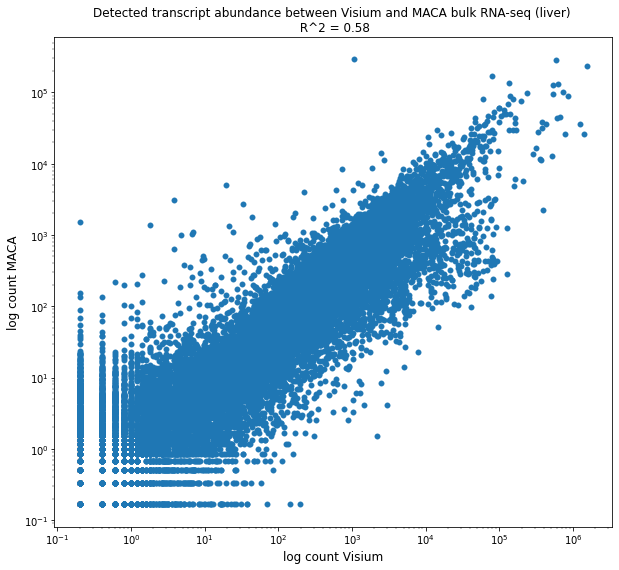

In [470]:
# Format data to be compared
#List of genes to be examined
# genes = VizgenCountsLiver[0]['gene'].copy()
# gene_list = genes.to_list() #Get gene list

# gene_list = [x.lower() for x in gene_list] #Convert to lower case

#MACA plates that are liver tissue
liver_plates = MACA_meta['Sample name'].copy()[MACA_meta['source name'].str.contains('Liver')] #Plates containing liver experiments
liver_plate_strings = liver_plates.to_list() #Convert to list of strings
liver_plate_strings = [s + '.gencode.vM19' for s in liver_plate_strings] #Append to every string to make compatible

#Get gene counts from MACA experiments that are liver tissue (reset gene column from index)
MACA_liver = MACA.copy()[liver_plate_strings].reset_index()

#Get the subset of MACA that intersect with Vizgen genes

#First, make gene list lower case
MACA_liver['gene'] = MACA_liver['gene'].str.lower()

#Calculate the average across all bulk RNA_seq experiments
MACA_liver['average'] = MACA_liver.mean(axis=1,skipna=True,numeric_only=True)

MACA_counts_perGene_liver = MACA_liver.mean(axis=1,skipna=True,numeric_only=True)

#Calculate average across Vizgen replicates
# VizgenLiver = pd.DataFrame(data=np.transpose([VizgenCountsLiver[i]['count'] 
#                                           for i in range(len(VizgenCountsLiver))]),
#                                          columns=[experimentNames[x] for x in liver_ind])
# VizgenLiver['average'] = VizgenLiver.mean(axis=1)
# VizgenLiver['gene'] = VizgenCountsLiver[0]['gene'].str.lower()

# Calculate the average across Visium experiments 
pseudo_bulk_counts_perGene_liver

# make the gene names as lower case
pseudo_bulk_counts_perGene_liver.index = pseudo_bulk_counts_perGene_liver.index.str.lower()
pseudo_bulk_counts_perGene_liver

df_visium_liver = pd.DataFrame(pseudo_bulk_counts_perGene_liver)
df_visium_liver = df_visium_liver.rename(columns={0:"average"})
df_visium_liver["gene"] = df_visium_liver.index
df_visium_liver

# Rename Vizgen genes that are inconsistent with MACA
# faim3 - fcmr (y)
# mir205hg - 4631405K08Rik (y)
# tmem27 - Cltrn (y)
# gpr116 - Adgrf5 (y)
# emr1 - Adgre1 (y)
# cybasc3 - Cyb561a3 (y)
# ptrf - Cavin1 (y)
# fam159b - Shisal2b (y)
# 1700011H14RIK - ccdc198 (y)
# rename_map = {'faim3':'fcmr',
#               'mir205hg':'4631405k08rik',
#              'tmem27':'cltrn',
#              'gpr116':'adgrf5',
#              'emr1':'adgre1',
#              'cybasc3':'cyb561a3',
#              'ptrf':'cavin1',
#              'fam159b':'shisal2b',
#              '1700011h14rik':'ccdc198'}
# for i in range(VizgenLiver.shape[0]):
#     if VizgenLiver.loc[i,'gene'] in rename_map.keys():
#         VizgenLiver.loc[i,'gene'] = rename_map[VizgenLiver.loc[i,'gene']]

# Get the intersection_liver with common genes
intersection_liver = df_visium_liver[['average','gene']].merge(MACA_liver[['average','gene']],
                                                           on='gene')
intersection_liver = intersection_liver.rename(columns={'average_x':'Visium_avg', 'average_y':'MACA_avg'})


# Plot results

# Correlation coefficient
R2_compare_liver = np.corrcoef(intersection_liver['Visium_avg'], intersection_liver['MACA_avg'])
R2_compare_liver = R2_compare_liver[1,0]

# Scatter plot of averages
plt.figure()
plt.scatter(intersection_liver['Visium_avg'], intersection_liver['MACA_avg'])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('log count Visium')
plt.ylabel('log count MACA')
plt.title('Detected transcript abundance between Visium and MACA bulk RNA-seq (liver) \n R^2 = ' 
          + str(round(R2_compare_liver,2)))

plt.show()

In [473]:
intersection_liver.set_index = "gene"
intersection_liver

,Visium_avg,gene,MACA_avg
0,0.000000,xkr4,4.833333
1,0.000000,gm1992,0.000000
2,0.000000,gm37381,2.000000
3,0.000000,rp1,15.166667
4,71.000000,sox17,27.666667
...,...,...,...
30713,558.799988,mt-nd4l,3.333333
30714,38238.000000,mt-nd4,17350.000000
30715,2432.399902,mt-nd5,13896.166667
30716,9.400000,mt-nd6,513.666667


### extra Panel : correlation between Visium and MACA bulk RNA-seq (mouse kidney)

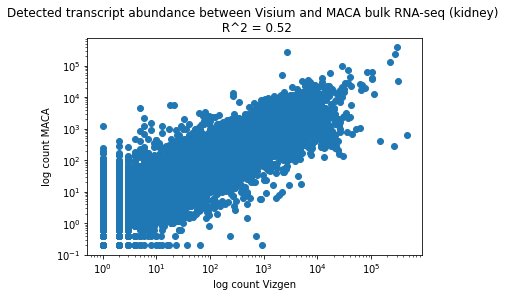

In [243]:
# Format data to be compared
#List of genes to be examined
# genes = VizgenCountsKidney[0]['gene'].copy()
# gene_list = genes.to_list() #Get gene list
# gene_list = [x.lower() for x in gene_list] #Convert to lower case

#MACA plates that are kidney tissue
kidney_plates = MACA_meta['Sample name'].copy()[MACA_meta['source name'].str.contains('Kidney')] #Plates containing kidney experiments
kidney_plate_strings = kidney_plates.to_list() #Convert to list of strings
kidney_plate_strings = [s + '.gencode.vM19' for s in kidney_plate_strings] #Append to every string to make compatible

#Get gene counts from MACA experiments that are kidney tissue (reset gene column from index)
MACA_kidney = MACA.copy()[kidney_plate_strings].reset_index()

#Get the subset of MACA that intersect with Vizgen genes
#First, make gene list lower case
MACA_kidney['gene'] = MACA_kidney['gene'].str.lower()

#Calculate the average across all bulk RNA_seq experiments
MACA_kidney['average'] = MACA_kidney.mean(axis=1,skipna=True,numeric_only=True)

#Calculate average across Vizgen replicates

#VizgenKidney = pd.DataFrame(data=np.transpose([VizgenCountsKidney[i]['count'] 
#                                          for i in range(len(VizgenCountsKidney))]),
#                                         columns=[experimentNames[x] for x in kidney_ind])
#VizgenKidney['average'] = VizgenKidney.mean(axis=1)
#VizgenKidney['gene'] = VizgenCountsKidney[0]['gene'].str.lower()

# Rename Vizgen genes that are inconsistent with MACA
# for i in range(VizgenKidney.shape[0]):
#     if VizgenKidney.loc[i,'gene'] in rename_map.keys():
#         VizgenKidney.loc[i,'gene'] = rename_map[VizgenKidney.loc[i,'gene']]


# Calculate the average across Visium experiments 
pseudo_bulk_counts_perGene_kidney

# make the gene names as lower case
pseudo_bulk_counts_perGene_kidney.index = pseudo_bulk_counts_perGene_kidney.index.str.lower()
pseudo_bulk_counts_perGene_kidney

df_visium_kidney = pd.DataFrame(pseudo_bulk_counts_perGene_kidney)
df_visium_kidney = df_visium_kidney.rename(columns={0:"average"})
df_visium_kidney["gene"] = df_visium_kidney.index
df_visium_kidney



# Get the intersection_kidney with common genes
intersection_kidney = df_visium_kidney[['average','gene']].merge(MACA_kidney[['average','gene']],
                                                           on='gene')
intersection_kidney = intersection_kidney.rename(columns={'average_x':'Visium_avg', 'average_y':'MACA_avg'})


# Plot results

# Correlation coefficient
R2_compare_kidney = np.corrcoef(intersection_kidney['Visium_avg'], intersection_kidney['MACA_avg'])
R2_compare_kidney = R2_compare_kidney[1,0]

# Scatter plot of averages
plt.figure()
plt.scatter(intersection_kidney['Visium_avg'], intersection_kidney['MACA_avg'])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('log count Vizgen')
plt.ylabel('log count MACA')
plt.title('Detected transcript abundance between Visium and MACA bulk RNA-seq (kidney) \n R^2 = ' 
          + str(round(R2_compare_kidney,2)))

plt.show()

### Panel C: correlation between Visium and MERFISH (Vizgen) - Mouse liver


In [493]:
df_visium_liver["gene"].shape[0]

31053

In [507]:
VizgenCountsLiver

[         gene    count  log count
 0       PTPRC   1774.0   3.249198
 1      PECAM1   1403.0   3.147367
 2         KDR    307.0   2.488551
 3        CDH5    748.0   2.874482
 4        CD19  12327.0   4.090893
 ..        ...      ...        ...
 302       LUM    108.0   2.037426
 303  SERPINF1  19371.0   4.287174
 304  CRISPLD2   2354.0   3.371991
 305     HTRA3   1589.0   3.201397
 306     AEBP1   2485.0   3.395501
 
 [307 rows x 3 columns],
          gene    count  log count
 0       PTPRC   1472.0   3.168203
 1      PECAM1   2475.0   3.393751
 2         KDR    973.0   2.988559
 3        CDH5   1881.0   3.274620
 4        CD19  14197.0   4.152227
 ..        ...      ...        ...
 302       LUM    256.0   2.409933
 303  SERPINF1  39894.0   4.600918
 304  CRISPLD2   2708.0   3.432809
 305     HTRA3   2007.0   3.302764
 306     AEBP1   4143.0   3.617420
 
 [307 rows x 3 columns],
          gene    count  log count
 0       PTPRC    801.0   2.904174
 1      PECAM1   1335.0   3.125806
 

In [523]:
df_visium_liver.index = np.arange(0,31053)
df_visium_liver

,average,gene
0,0.000000,xkr4
1,0.000000,gm1992
2,0.000000,gm37381
3,0.000000,rp1
4,71.000000,sox17
...,...,...
31048,0.000000,ac168977.1
31049,2777.800049,ac149090.1
31050,1129.400024,caaa01118383.1
31051,0.000000,vmn2r122


In [525]:
len(df_visium_liver)

31053

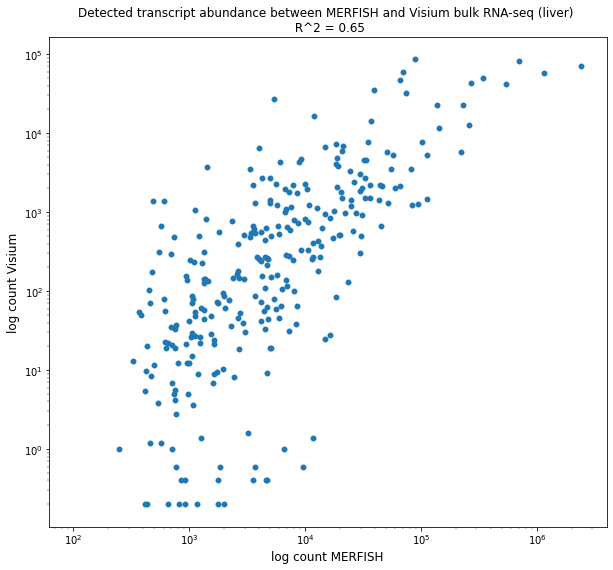

In [526]:
# Format data to be compared
#List of genes to be examined
genes = VizgenCountsLiver[0]['gene'].copy()
gene_list = genes.to_list() #Get gene list

gene_list = [x.lower() for x in gene_list] #Convert to lower case

#Calculate average across Vizgen replicates
VizgenLiver = pd.DataFrame(data=np.transpose([VizgenCountsLiver[i]['count'] 
                                          for i in range(len(VizgenCountsLiver))]),
                                         columns=[experimentNames[x] for x in liver_ind])
VizgenLiver['average'] = VizgenLiver.mean(axis=1)
VizgenLiver['gene'] = VizgenCountsLiver[0]['gene'].str.lower()

# Calculate the average across Visium experiments 
pseudo_bulk_counts_perGene_liver

# make the gene names as lower case
pseudo_bulk_counts_perGene_liver.index = pseudo_bulk_counts_perGene_liver.index.str.lower()
pseudo_bulk_counts_perGene_liver

df_visium_liver = pd.DataFrame(pseudo_bulk_counts_perGene_liver)
df_visium_liver = df_visium_liver.rename(columns={0:"average"})
df_visium_liver["gene"] = df_visium_liver.index
df_visium_liver.index = np.arange(0,len(df_visium_liver))
df_visium_liver

# Rename Vizgen and Visium genes that are inconsistent with MACA
# faim3 - fcmr (y)
# mir205hg - 4631405K08Rik (y)
# tmem27 - Cltrn (y)
# gpr116 - Adgrf5 (y)
# emr1 - Adgre1 (y)
# cybasc3 - Cyb561a3 (y)
# ptrf - Cavin1 (y)
# fam159b - Shisal2b (y)
# 1700011H14RIK - ccdc198 (y)
rename_map = {'faim3':'fcmr',
              'mir205hg':'4631405k08rik',
             'tmem27':'cltrn',
             'gpr116':'adgrf5',
             'emr1':'adgre1',
             'cybasc3':'cyb561a3',
             'ptrf':'cavin1',
             'fam159b':'shisal2b',
             '1700011h14rik':'ccdc198'}
for i in range(VizgenLiver.shape[0]):
    if VizgenLiver.loc[i,'gene'] in rename_map.keys():
        VizgenLiver.loc[i,'gene'] = rename_map[VizgenLiver.loc[i,'gene']]

for i in range(df_visium_liver["gene"].shape[0]):
    if df_visium_liver.loc[i,"gene"] in rename_map.keys():
        df_visium_liver.loc[i,"gene"] = rename_map[df_visium_liver.loc[i,"gene"]]

        
# Get the intersection_liver with common genes
intersection_liver = VizgenLiver[['average','gene']].merge(df_visium_liver[['average','gene']],
                                                           on='gene')
intersection_liver = intersection_liver.rename(columns={'average_x':'Vizgen_avg', 'average_y':'Visium_avg'})


# Plot results

# Correlation coefficient
R2_compare_liver = np.corrcoef(intersection_liver['Vizgen_avg'], intersection_liver['Visium_avg'])
R2_compare_liver = R2_compare_liver[1,0]

# Scatter plot of averages
plt.figure()
plt.scatter(intersection_liver['Vizgen_avg'], intersection_liver['Visium_avg'])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('log count MERFISH')
plt.ylabel('log count Visium')
plt.title('Detected transcript abundance between MERFISH and Visium bulk RNA-seq (liver) \n R^2 = ' 
          + str(round(R2_compare_liver,2)))

plt.show()

In [527]:
VizgenLiver

,Msliver_VZG116_021121,Msliver_VZG116_021221,Msliver_VZG116_021621,Msliver_VZG116_021721,MsLiver_Cellbound_VZG116_V1_JH_09-18-2021,average,gene
0,1774.0,1472.0,801.0,4859.0,4235.0,2628.2,ptprc
1,1403.0,2475.0,1335.0,6544.0,4967.0,3344.8,pecam1
2,307.0,973.0,736.0,4583.0,18355.0,4990.8,kdr
3,748.0,1881.0,1317.0,4386.0,12254.0,4117.2,cdh5
4,12327.0,14197.0,11762.0,39666.0,3308.0,16252.0,cd19
...,...,...,...,...,...,...,...
302,108.0,256.0,174.0,647.0,1668.0,570.6,lum
303,19371.0,39894.0,18105.0,77038.0,558014.0,142484.4,serpinf1
304,2354.0,2708.0,1612.0,4851.0,1994.0,2703.8,crispld2
305,1589.0,2007.0,1272.0,3539.0,2498.0,2181.0,htra3


In [528]:
df_visium_liver

,average,gene
0,0.000000,xkr4
1,0.000000,gm1992
2,0.000000,gm37381
3,0.000000,rp1
4,71.000000,sox17
...,...,...
31048,0.000000,ac168977.1
31049,2777.800049,ac149090.1
31050,1129.400024,caaa01118383.1
31051,0.000000,vmn2r122


**Note** 

The number of genes in Vizgen/MERFISH dataset is 307, and Visium dataset is 31053. After subsetting, we get 307 genes.

In [529]:
list(set(VizgenLiver["gene"]) - set(df_visium_liver["gene"]))

[]

In [530]:
intersection_liver

,Vizgen_avg,gene,Visium_avg
0,2628.2,ptprc,180.199997
1,3344.8,pecam1,480.000000
2,4990.8,kdr,1417.000000
3,4117.2,cdh5,553.200012
4,16252.0,cd19,28.000000
...,...,...,...
302,570.6,lum,657.200012
303,142484.4,serpinf1,11655.200195
304,2703.8,crispld2,18.600000
305,2181.0,htra3,78.199997


### Panel D: correlation between MERFISH and Visium (mouse kidney)


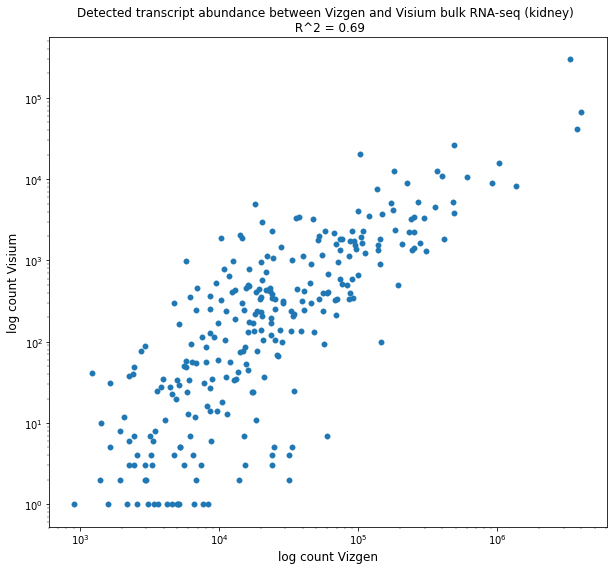

In [531]:
# Format data to be compared
#List of genes to be examined
genes = VizgenCountsKidney[0]['gene'].copy()
gene_list = genes.to_list() #Get gene list
gene_list = [x.lower() for x in gene_list] #Convert to lower case

#Calculate average across Vizgen replicates

VizgenKidney = pd.DataFrame(data=np.transpose([VizgenCountsKidney[i]['count'] 
                                         for i in range(len(VizgenCountsKidney))]),
                                        columns=[experimentNames[x] for x in kidney_ind])
VizgenKidney['average'] = VizgenKidney.mean(axis=1)
VizgenKidney['gene'] = VizgenCountsKidney[0]['gene'].str.lower()

# Rename Vizgen genes that are inconsistent with MACA
for i in range(VizgenKidney.shape[0]):
    if VizgenKidney.loc[i,'gene'] in rename_map.keys():
        VizgenKidney.loc[i,'gene'] = rename_map[VizgenKidney.loc[i,'gene']]


# Calculate the average across Visium experiments 
pseudo_bulk_counts_perGene_kidney

# make the gene names as lower case
pseudo_bulk_counts_perGene_kidney.index = pseudo_bulk_counts_perGene_kidney.index.str.lower()
pseudo_bulk_counts_perGene_kidney

df_visium_kidney = pd.DataFrame(pseudo_bulk_counts_perGene_kidney)
df_visium_kidney = df_visium_kidney.rename(columns={0:"average"})
df_visium_kidney["gene"] = df_visium_kidney.index
df_visium_kidney



# Get the intersection_kidney with common genes
intersection_kidney = VizgenKidney[['average','gene']].merge(df_visium_kidney[['average','gene']],
                                                           on='gene')
intersection_kidney = intersection_kidney.rename(columns={'average_x':'Vizgen_avg', 'average_y':'Visium_avg'})


# Plot results

# Correlation coefficient
R2_compare_kidney = np.corrcoef(intersection_kidney['Vizgen_avg'], intersection_kidney['Visium_avg'])
R2_compare_kidney = R2_compare_kidney[1,0]

# Scatter plot of averages
plt.figure()
plt.scatter(intersection_kidney['Vizgen_avg'], intersection_kidney['Visium_avg'])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('log count Vizgen')
plt.ylabel('log count Visium')
plt.title('Detected transcript abundance between Vizgen and Visium bulk RNA-seq (kidney) \n R^2 = ' 
          + str(round(R2_compare_kidney,2)))

plt.show()

In [295]:
intersection_kidney

,Vizgen_avg,gene,Visium_avg
0,5798.5,ptprc,58.0
1,11753.0,pecam1,648.0
2,100120.5,kdr,664.0
3,70346.5,cdh5,338.0
4,8364.0,cd19,1.0
...,...,...,...
301,2729.5,lum,77.0
302,6802.5,serpinf1,55.0
303,28700.5,crispld2,296.0
304,8847.5,htra3,35.0


### Panel E: histogram of ratio of counts per gene in liver (averaged across experiments)

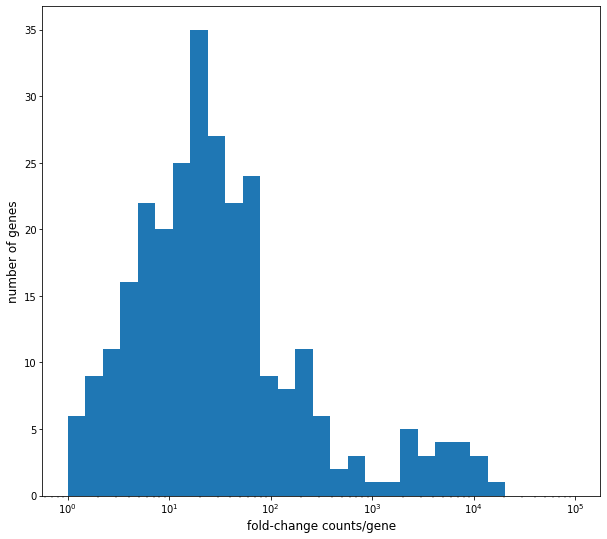

In [532]:
bins = np.logspace(0,5,30)

plt.figure()
plt.hist(intersection_liver['Vizgen_avg'] / intersection_liver['Visium_avg'], bins=bins)
plt.xlabel('fold-change counts/gene')
plt.ylabel('number of genes')
plt.xscale('log')

plt.show()

### Panel F: histogram of counts per gene in kidney (averaged across experiments)

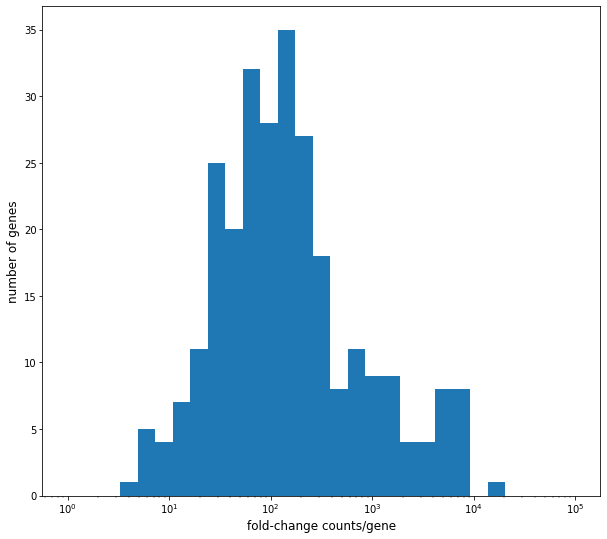

In [533]:
bins = np.logspace(0,5,30)

plt.figure()
plt.hist(intersection_kidney['Vizgen_avg'] / intersection_kidney['Visium_avg'], bins=bins)
plt.xlabel('fold-change counts/gene')
plt.ylabel('number of genes')
plt.xscale('log')

plt.show()

In [534]:
intersection_liver

,Vizgen_avg,gene,Visium_avg
0,2628.2,ptprc,180.199997
1,3344.8,pecam1,480.000000
2,4990.8,kdr,1417.000000
3,4117.2,cdh5,553.200012
4,16252.0,cd19,28.000000
...,...,...,...
302,570.6,lum,657.200012
303,142484.4,serpinf1,11655.200195
304,2703.8,crispld2,18.600000
305,2181.0,htra3,78.199997


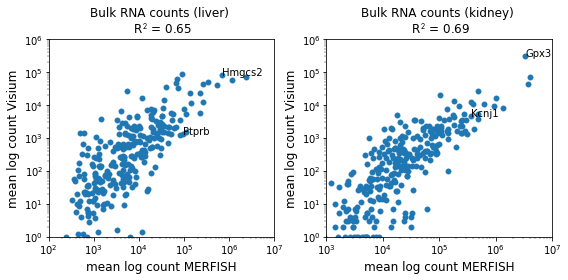

In [537]:
set_plotting_style()
# Plot the whole figure
fig, axes = plt.subplots(1,2, figsize=(8,4))

# # Panel A
# i = 0
# j = 1
# ax = axes[0,0]
# ax.scatter(VizgenCountsLiver[i]['count'],VizgenCountsLiver[j]['count'])
# ax.set_xlabel('log count replicate 1')
# ax.set_ylabel('log count replicate 2')
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_title('Technical replicates (liver) \n R$^2$ = ' + str(round(R2_reps_liver,2)))

# # Panel B
# i = 0
# j = 1
# ax = axes[0,1]
# ax.scatter(VizgenCountsKidney[i]['count'],VizgenCountsKidney[j]['count'])
# ax.set_xlabel('log count replicate 1')
# ax.set_ylabel('log count replicate 2')
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_title('Technical replicates (kidney) \n R$^2$ = ' + str(round(R2_reps_kidney,2)))

# Panel C
ax = axes[0]
ax.scatter(intersection_liver['Vizgen_avg'], intersection_liver['Visium_avg'])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim((1e2,1e7))
ax.set_ylim((1e0,1e6))
ax.set_xlabel('mean log count MERFISH')
ax.set_ylabel('mean log count Visium')
ax.set_title('Bulk RNA counts (liver) \n R$^2$ = ' 
          + str(round(R2_compare_liver,2)))

# Annotate some genes
hmgcs2 = intersection_liver[intersection_liver['gene'] == 'hmgcs2']
ptprb = intersection_liver[intersection_liver['gene'] == 'ptprb']

ax.text(hmgcs2['Vizgen_avg'], hmgcs2['Visium_avg'], 'Hmgcs2')
ax.text(ptprb['Vizgen_avg'], ptprb['Visium_avg'], 'Ptprb')

                  
# Panel D
ax = axes[1]
ax.scatter(intersection_kidney['Vizgen_avg'], intersection_kidney['Visium_avg'])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim((1e3,1e7))
ax.set_ylim((1e0,1e6))
ax.set_xlabel('mean log count MERFISH')
ax.set_ylabel('mean log count Visium')
ax.set_title('Bulk RNA counts (kidney) \n R$^2$ = ' 
          + str(round(R2_compare_kidney,2)))

# Annotate some genes
gpx3 = intersection_kidney[intersection_kidney['gene'] == 'gpx3']
kcnj1 = intersection_kidney[intersection_kidney['gene'] == 'kcnj1']

ax.text(gpx3['Vizgen_avg'], gpx3['Visium_avg'], 'Gpx3')
ax.text(kcnj1['Vizgen_avg'], kcnj1['Visium_avg'], 'Kcnj1')

# # Panel E
# ax = axes[2,0]
# bins = np.logspace(0,5,30)

# ax.hist(intersection_liver['Vizgen_avg'] / intersection_liver['MACA_avg'], bins=bins)
# ax.set_xlabel('fold-change mean counts/gene')
# ax.set_ylabel('number of genes')
# ax.set_xscale('log')
# #ax.legend()
# #ax.set_title('counts per gene, liver')

# # Panel F
# ax = axes[2,1]
# bins = np.logspace(0,5,30)

# ax.hist(intersection_kidney['Vizgen_avg'] / intersection_kidney['MACA_avg'], bins=bins)
# ax.set_xlabel('fold-change mean counts/gene')
# ax.set_ylabel('number of genes')
# ax.set_xscale('log')
# #ax.legend()
# #ax.set_title('counts per gene, kidney')

# Label subpanels
# axes_flat = axes.flat
# for n, ax in enumerate(axes_flat):
#     ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, 
#             size=20, weight='bold')

fig.tight_layout()
plt.show()

In [312]:
# Export figures
fig.savefig('../../figures/SIFig_bulkanalysis_MERFISH_Visium.svg', transparent=True)
fig.savefig('../../figures/SIFig_bulkanalysis_MERFISH_Visium.png', transparent=True)
fig.savefig('../../figures/SIFig_bulkanalysis_MERFISH_Visium.pdf', transparent=True)

print('Figures saved.')

Figures saved.
